## Spatial frequencies' sampling for the CPSD

In this example, we plot the phase and Zernike CPSD before integrating them over the spatial frequencies (we consider the perpendicular component of the frequency wrt the wind vector).

The aim is to show that the phase integrand oscillates very quickly around 0 (being 0 on average) in the range of high temporal and spatial frequencies. Therefore, it is important to choose the spatial frequency range with the proper sampling in order not to overestimate the phase CPSD (e.g. good_spat_freqs = np.logspace(-3, 3, 1000)).

This is not as much important for the Zernike CPSD, because the Zernike integrand is not 0 on average in the range of high temporal and spatial frequencies (not so true...). 

In [11]:
import numpy as np
import astropy.units as u
from apposto.types.guide_source import GuideSource
from apposto.types.aperture import CircularOpticalAperture
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance
from apposto.atmo.cn2_profile import Cn2Profile

source1 = GuideSource((0*u.arcsec, 0*u.deg), np.inf*u.m)
source2 = GuideSource((50*u.arcsec, 30*u.deg), 100e3*u.m)
aperture1 = CircularOpticalAperture(5*u.m, [0, 0, 0]*u.m)
aperture2 = CircularOpticalAperture(5*u.m, [0, 0, 0]*u.m)
cn2 = Cn2Profile.from_r0s(layersR0=[16]*u.cm, layersL0=[25]*u.m, layersAltitude=[10]*u.km,
                                   layersWindSpeed=[10]*u.m/u.s, layersWindDirection=[-20]*u.deg)
temp_freqs = np.linspace(0.05, 250, 5000)
spat_freqs = np.logspace(-3, 3, 1000)

mode_j = 2
mode_k = 5

vk = VonKarmanSpatioTemporalCovariance(source1=source1, source2=source2, aperture1=aperture1, aperture2=aperture2,
                                        cn2_profile=cn2, spat_freqs=spat_freqs)
phaseIntegrand, _ = vk.integrandOfPhaseCPSD(nLayer=0, temp_freq=temp_freqs[4000])
zernikeIntegrand, _ = vk.integrandOfZernikeCPSD(j=mode_j, k=mode_k, nLayer=0, temp_freq=temp_freqs[4000])

Here, we plot the phase and zernike integrand functions.

Text(0.5, 1.0, 'Zernike')

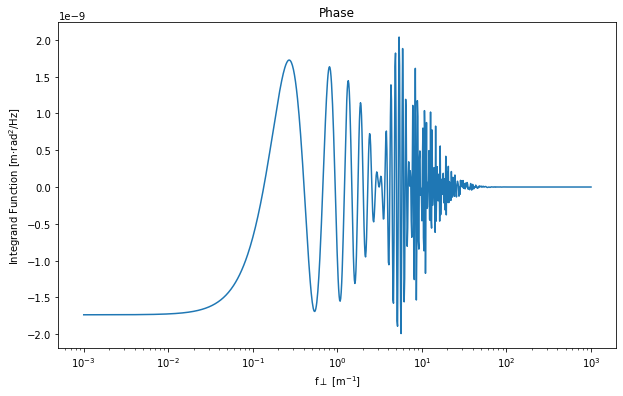

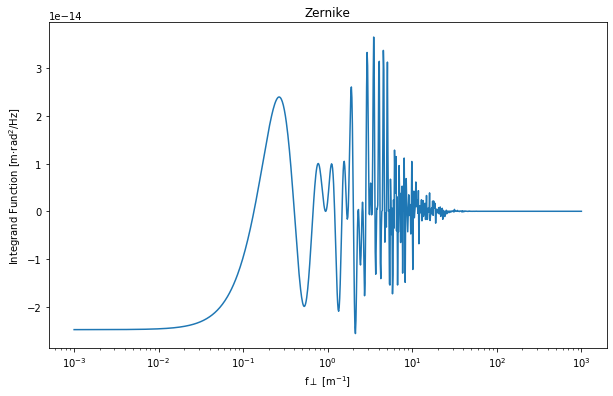

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.semilogx(spat_freqs, np.real(phaseIntegrand))
plt.xlabel('f${\perp}$ [m$^{-1}$]')
plt.ylabel('Integrand Function [m$\cdot$rad$^{2}$/Hz]')
plt.title('Phase')

plt.figure()
plt.semilogx(spat_freqs, np.real(zernikeIntegrand))
plt.xlabel('f${\perp}$ [m$^{-1}$]')
plt.ylabel('Integrand Function [m$\cdot$rad$^{2}$/Hz]')
plt.title('Zernike')

In [13]:
mode_j = 2
mode_k = 5

vk.setSpatialFrequencies(spat_freqs)
phaseCpsdGoodSampling = vk.getPhaseCPSD(temp_freqs=temp_freqs)
zernikeCpsdGoodSampling = vk.getZernikeCPSD(j=mode_j, k=mode_k, temp_freqs=temp_freqs)

spat_freqs_bad_sampling = np.logspace(-3, 3, 100)
vk.setSpatialFrequencies(spat_freqs_bad_sampling)
phaseCpsdBadSampling = vk.getPhaseCPSD(temp_freqs)
zernikeCpsdBadSampling = vk.getZernikeCPSD(j=mode_j, k=mode_k, temp_freqs=temp_freqs)

Here, we plot the phase and zernike CPSD. 
We can see that the sampling choice has a large effect on the phase CPSD.

Text(0.5, 1.0, 'Zernike')

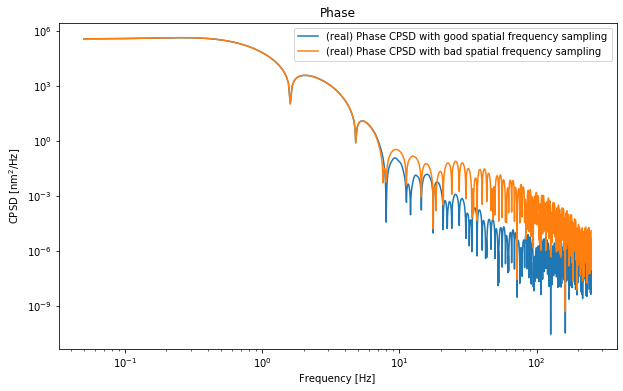

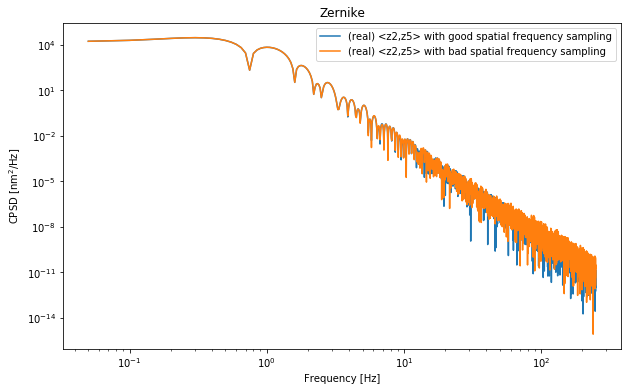

In [14]:
plt.figure()
vk.plotCPSD(phaseCpsdGoodSampling, temp_freqs, 'real', 'log', legend='Phase CPSD with good spatial frequency sampling', wavelength=5e-7)
vk.plotCPSD(phaseCpsdBadSampling, temp_freqs, 'real', 'log', legend='Phase CPSD with bad spatial frequency sampling',wavelength=5e-7)
plt.title('Phase')

plt.figure()
vk.plotCPSD(zernikeCpsdGoodSampling, temp_freqs, 'real', 'log', legend='<z2,z5> with good spatial frequency sampling',wavelength=5e-7)
vk.plotCPSD(zernikeCpsdBadSampling, temp_freqs, 'real', 'log', legend='<z2,z5> with bad spatial frequency sampling', wavelength=5e-7)
plt.title('Zernike')

## Test against alternative code
A simple check against IDL oaa_lib developed in Arcetri. The variance of tilt for a D=10m telescope, with L0=25m and r0=0.16m @ 500nm is 

```
IDL> d=10. & L0=25. & r0=0.16 & scale=(d/r0)^(5./3) & L0n=L0/d
IDL> sqrt(von_covar(2, 2 , L0n) * scale) * 500                
       544.88968962380648
```

Below we reproduce the same result

In [15]:
import astropy.units as u
source = GuideSource((0, 0), np.inf)
aperture = CircularOpticalAperture(5, [0, 0, 0])
cn2 = Cn2Profile.from_r0s(layersR0=[0.16], layersL0=[25], layersAltitude=[100],
                                   layersWindSpeed=[10], layersWindDirection=[-20])
temp_freqs = np.linspace(0.05, 250, 5000)
spat_freqs = np.logspace(-3, 3, 1000)

vk = VonKarmanSpatioTemporalCovariance(source1=source, source2=source, aperture1=aperture, aperture2=aperture,
                                        cn2_profile=cn2, spat_freqs=spat_freqs)
dum = vk.getZernikeCovariance(j=2, k=2)
print(np.sqrt(np.abs(dum)) * (500*u.nm / (2*np.pi*u.rad)))

544.9482889137599 nm


## Test the comparison between covariance and integrated CPSD

In [21]:
import numpy as np
from apposto.types.guide_source import GuideSource
from apposto.types.aperture import CircularOpticalAperture
from apposto.atmo.cn2_profile import Cn2Profile
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance

source = GuideSource((0, 0), np.inf)
aperture1 = CircularOpticalAperture(5, [0, 0, 0])
aperture2 = CircularOpticalAperture(5, [0, 0, 0])
cn2_profile = Cn2Profile.from_r0s([0.16], [25], [10e3], [10], [-20])
spatial_freqs = np.logspace(-4, 4, 1000)
#temp_freqs = np.linspace(0.05, 250, 5000)
temp_freqs = np.logspace(-3, 3, 1000)

vk = VonKarmanSpatioTemporalCovariance(source1=source, source2=source, aperture1=aperture1, aperture2=aperture2,
                                           cn2_profile=cn2_profile, spat_freqs=spatial_freqs)

phaseCovariance = vk.getPhaseCovariance()
phaseCPSD = vk.getPhaseCPSD(temp_freqs)

import astropy.units as u
phaseCovFromCPSD = np.trapz(2*np.real(phaseCPSD) ,temp_freqs*u.Hz)

In [22]:
print('Phase covariance: {}'.format(phaseCovariance))
print('Phase covariance from CPSD integration: {}'.format(phaseCovFromCPSD))
print('Ratio: {}'.format(phaseCovariance/phaseCovFromCPSD))

Phase covariance: (190.1521316706498+0j) rad2
Phase covariance from CPSD integration: 189.80279499246706 rad2
Ratio: (1.0018405244148096+0j)


In [11]:
zernikeCovariance = vk.getZernikeCovariance(2, 2)
zernikeCPSD = vk.getZernikeCPSD(2, 2, temp_freqs)
zernikeGeneralCPSD = vk.getGeneralZernikeCPSD(2, 2, temp_freqs)

zernikeCovFromCPSD = 2 * np.trapz(np.real(zernikeCPSD), temp_freqs * u.Hz)
zernikeCovFromGeneralCPSD = np.trapz(zernikeGeneralCPSD, temp_freqs * u.Hz)

In [12]:
print('Zernike covariance: {}'.format(zernikeCovariance))
print('Zernike covariance from CPSD integration: {}'.format(zernikeCovFromCPSD))
print('Zernike covariance from general CPSD integration: {}'.format(zernikeCovFromGeneralCPSD))
print('Ratio: {}'.format(zernikeCovariance/zernikeCovFromCPSD))

Zernike covariance: (47.04670478749887+0j) rad2
Zernike covariance from CPSD integration: 45.92998032027694 rad2
Zernike covariance from general CPSD integration: (45.92998032027695+0j) rad2
Ratio: (1.0243136282540257+0j)


## Zernike correlation and residuals as a function of off-axis guide star angular distance


In [16]:
import numpy as np
import astropy.units as u
from apposto.types.guide_source import GuideSource
from apposto.types.aperture import CircularOpticalAperture
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance
from apposto.atmo.cn2_profile import Cn2Profile

cn2 = Cn2Profile.from_r0s([16]*u.cm, [25]*u.m, [10]*u.km, [10]*u.m/u.s, [-20]*u.deg)              
sourceOnAxis = GuideSource((0*u.arcsec, 0*u.deg), np.inf*u.m)                                         
aperture1 = CircularOpticalAperture(5*u.m, [0, 0, 0]*u.m)                                    
aperture2 = CircularOpticalAperture(5*u.m, [0, 0, 0]*u.m)
spatial_freqs = np.logspace(-3, 3, 100)

In [17]:
def correlationParameter(cov_onon, cov_onoff):
    return cov_onoff/cov_onon

def correlationParameterVsAngularDistance(distance_range, j, k):
    vk = VonKarmanSpatioTemporalCovariance(source1=sourceOnAxis, source2=sourceOnAxis, aperture1=aperture1,
                                       aperture2=aperture2, cn2_profile=cn2, spat_freqs=spatial_freqs)
    covOnOn = vk.getZernikeCovariance(j,k)
    correlationParams = [] 
    for i in distance_range:
        sourceOff = GuideSource((i*u.arcsec, 0*u.deg), np.inf*u.m) 
        vk.setSource2(sourceOff) 
        covOnOff = vk.getZernikeCovariance(j,k) 
        corr = correlationParameter(covOnOn, covOnOff) 
        correlationParams.append(corr) 
    return correlationParams, covOnOn

def residualOfCorrectionUsingOffAxisGuideStar(correlationParameter, cov_onon):
    sigma_res = np.sqrt(2*(1 - correlationParameter)*cov_onon)
    return sigma_res

def correlationParameterVsOuterScale(outer_scales, j, k):
    vk = VonKarmanSpatioTemporalCovariance(source1=sourceOnAxis, source2=sourceOnAxis, aperture1=aperture1,
                                       aperture2=aperture2, cn2_profile=cn2, spat_freqs=spatial_freqs)
    for L0 in outer_scales:
        cn2 = Cn2Profile.from_r0s([16]*u.cm, [L0]*u.m, [10]*u.km, [10]*u.m/u.s, [-20]*u.deg)
        vk.setCn2Profile(cn2)
        correlation = correlationParameterVsAngularDistance()
    return correlationParams, covOnOn

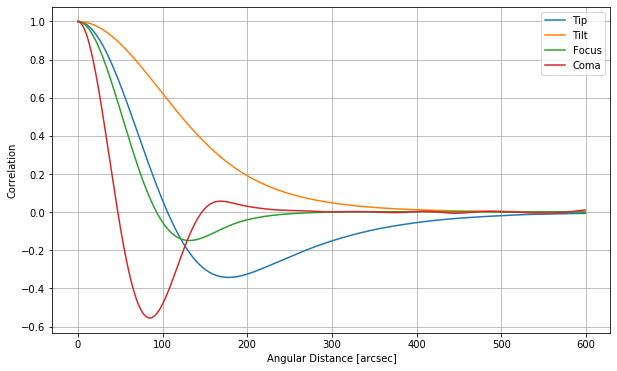

In [18]:
distances = np.arange(0, 600)
correlation22, covOnOn22 = correlationParameterVsAngularDistance(distances, 2, 2)
correlation33,covOnOn33 = correlationParameterVsAngularDistance(distances, 3, 3)
correlation44, covOnOn44 = correlationParameterVsAngularDistance(distances, 4, 4)
correlation88, covOnOn88 = correlationParameterVsAngularDistance(distances, 8, 8)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(distances, np.real(correlation22), label='Tip')
plt.plot(distances, np.real(correlation33), label='Tilt')
plt.plot(distances, np.real(correlation44), label='Focus')
plt.plot(distances, np.real(correlation88), label='Coma')
plt.xlabel('Angular Distance [arcsec]')
plt.ylabel('Correlation')
plt.legend()
plt.grid()
plt.show()

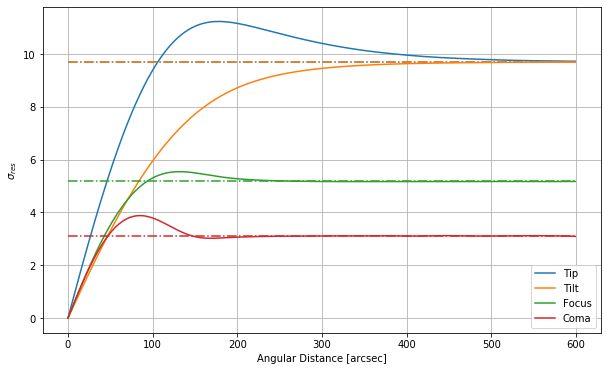

In [19]:
res22 = np.array([residualOfCorrectionUsingOffAxisGuideStar(corr, covOnOn22) for corr in correlation22])
res33 = np.array([residualOfCorrectionUsingOffAxisGuideStar(corr, covOnOn33) for corr in correlation33])
res44 = np.array([residualOfCorrectionUsingOffAxisGuideStar(corr, covOnOn44) for corr in correlation44])
res88 = np.array([residualOfCorrectionUsingOffAxisGuideStar(corr, covOnOn88) for corr in correlation88])

saturationRes22 = np.ones(distances.shape)*residualOfCorrectionUsingOffAxisGuideStar(0, covOnOn22)
saturationRes33 = np.ones(distances.shape)*residualOfCorrectionUsingOffAxisGuideStar(0, covOnOn33)
saturationRes44 = np.ones(distances.shape)*residualOfCorrectionUsingOffAxisGuideStar(0, covOnOn44)
saturationRes88 = np.ones(distances.shape)*residualOfCorrectionUsingOffAxisGuideStar(0, covOnOn88)


cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["figure.figsize"] = (10,6)

plt.plot(distances, np.real(res22), label='Tip', color=cycle[0])
plt.plot(distances, np.real(saturationRes22), '-.', color=cycle[0])

plt.plot(distances, np.real(res33), label='Tilt', color=cycle[1])
plt.plot(distances, np.real(saturationRes33), '-.', color=cycle[1])

plt.plot(distances, np.real(res44), label='Focus', color=cycle[2])
plt.plot(distances, np.real(saturationRes44), '-.', color=cycle[2])

plt.plot(distances, np.real(res88), label='Coma', color=cycle[3])
plt.plot(distances, np.real(saturationRes88), '-.', color=cycle[3])
plt.xlabel('Angular Distance [arcsec]')
plt.ylabel('$\sigma_{res}$')
plt.legend()
plt.grid()
plt.show()

# Cutoff frequency of Zernike CPSD using one source at infinity and one aperture

If we consider one source at infinity and one aperture, the cutoff frequency of Zernike CPSD depends on the Zernike radial degree $n$, the wind velocity $V$ and the aperture diameter $D$ according to this relationship (J.M.Conan, 1995): $\nu_{c} \sim 0.3 (n+1)V/D$

Here, we test the dependence on the Zernike radial degree $n$. 

In [20]:
import numpy as np
from apposto.types.guide_source import GuideSource 
from apposto.types.aperture import CircularOpticalAperture 
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance 
from apposto.atmo.cn2_profile import Cn2Profile                                                                                     

rho, theta = (0,0)
aperture_radius = 5
aperture_centre = [0, 0, 0]
r0 = [0.16]
L0 = [25]
layers_altitude = [10e3]
wind_speed = [10]
wind_direction = [0]

source = GuideSource((rho, theta), np.inf)                                                                                                                                                                                    
aperture = CircularOpticalAperture(aperture_radius, aperture_centre)                                                                                   
cn2 = Cn2Profile.from_r0s(r0, L0, layers_altitude, wind_speed, wind_direction)
spatial_freqs = np.logspace(-3, 3, 100)                                                                                                     
temporal_freqs = np.linspace(0.05, 250, 5000)                                                                                           

vk = VonKarmanSpatioTemporalCovariance(source1=source, source2=source, aperture1=aperture, aperture2=aperture,
                                       cn2_profile=cn2, spat_freqs=spatial_freqs)

zz22 = vk.getZernikeCPSD(2, 2, temporal_freqs)
zz88 = vk.getZernikeCPSD(8, 8, temporal_freqs)
zz22_22 = vk.getZernikeCPSD(22, 22, temporal_freqs)

cutoff22 = temporal_freqs[11]
cutoff88 = temporal_freqs[23]
cutoff22_22 = temporal_freqs[41]                                                                

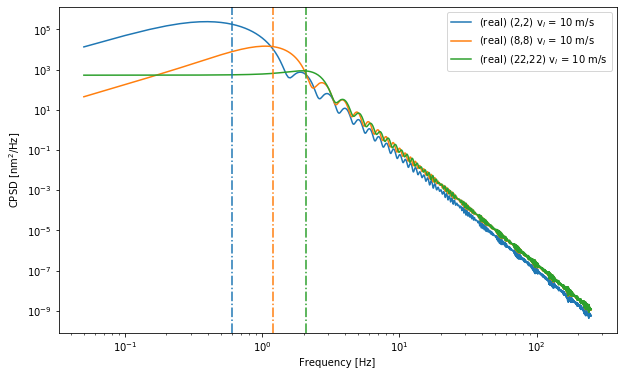

In [21]:
plt.rcParams["figure.figsize"] = (10,6)
vk.plotCPSD(zz22, temporal_freqs, 'real', 'log', '(2,2) v$_{l}$ = 10 m/s')                                                             
vk.plotCPSD(zz88, temporal_freqs, 'real', 'log', '(8,8) v$_{l}$ = 10 m/s')                                                             
vk.plotCPSD(zz22_22, temporal_freqs, 'real', 'log', '(22,22) v$_{l}$ = 10 m/s')                                                        

import matplotlib.pyplot as plt
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.axvline(cutoff22, linestyle='-.', color=cycle[0])                                                                        
plt.axvline(cutoff88, linestyle='-.', color=cycle[1])                                                                        
plt.axvline(cutoff22_22, linestyle='-.', color=cycle[2]) 

Here, we test the dependence on the wind velocity.

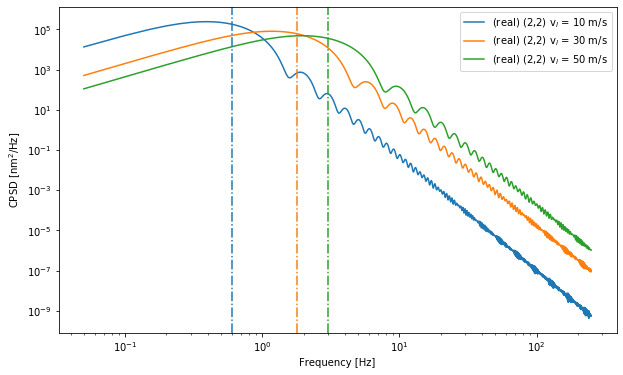

In [22]:
wind_velocities = np.array([10, 30, 50])                                                                                                      
j = 2
k = 2

zernikeCpsds = [] 
for v in wind_velocities:
    cn2 = Cn2Profile.from_r0s([0.16], [25], [10e3], [v], [0]) 
    vk.setCn2Profile(cn2) 
    cpsd = vk.getZernikeCPSD(j, k, temporal_freqs) 
    zernikeCpsds.append(cpsd)
    
vk.plotCPSD(zernikeCpsds[0], temporal_freqs, 'real', 'log', '(2,2) v$_{l}$ = 10 m/s')                                                         
vk.plotCPSD(zernikeCpsds[1], temporal_freqs, 'real', 'log', '(2,2) v$_{l}$ = 30 m/s')                                                         
vk.plotCPSD(zernikeCpsds[2], temporal_freqs, 'real', 'log', '(2,2) v$_{l}$ = 50 m/s')

cutoff_v1 = temporal_freqs[11]                                                                                                                     
cutoff_v2 = temporal_freqs[35]                                                                                                                     
cutoff_v3 = temporal_freqs[59]                                                                                                                     

plt.axvline(cutoff_v1, linestyle='-.', color=cycle[0])                                                                        
plt.axvline(cutoff_v2, linestyle='-.', color=cycle[1])                                                                        
plt.axvline(cutoff_v3, linestyle='-.', color=cycle[2]) 

Here, we test the dependence on the aperture diameter.

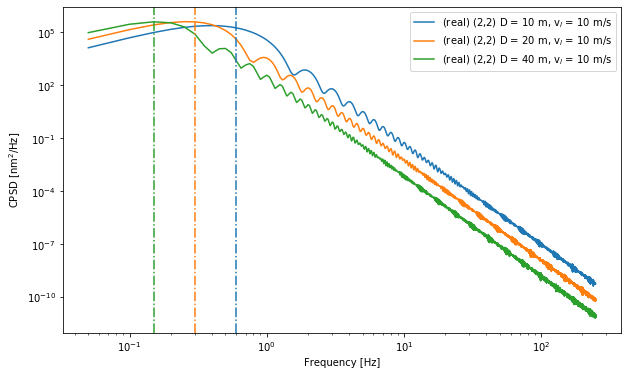

In [23]:
cn2 = Cn2Profile.from_r0s([0.16], [25], [10e3], [10], [0])
vk.setCn2Profile(cn2)
aperture_diameters = np.array([10, 20, 40])                                                                                                      
j = 2
k = 2

zernikeCpsds = [] 
for d in aperture_diameters:
    aperture = CircularOpticalAperture(d/2, [0, 0, 0])
    vk.setAperture1(aperture)
    vk.setAperture2(aperture)
    cpsd = vk.getZernikeCPSD(j, k, temporal_freqs) 
    zernikeCpsds.append(cpsd)
    
vk.plotCPSD(zernikeCpsds[0], temporal_freqs, 'real', 'log', '(2,2) D = 10 m, v$_{l}$ = 10 m/s')                                                         
vk.plotCPSD(zernikeCpsds[1], temporal_freqs, 'real', 'log', '(2,2) D = 20 m, v$_{l}$ = 10 m/s')                                                         
vk.plotCPSD(zernikeCpsds[2], temporal_freqs, 'real', 'log', '(2,2) D = 40 m, v$_{l}$ = 10 m/s')

cutoff_d1 = temporal_freqs[11]                                                                                                                     
cutoff_d2 = temporal_freqs[5]                                                                                                                     
cutoff_d3 = temporal_freqs[2]    

plt.axvline(cutoff_d1, linestyle='-.', color=cycle[0])                                                                        
plt.axvline(cutoff_d2, linestyle='-.', color=cycle[1])                                                                        
plt.axvline(cutoff_d3, linestyle='-.', color=cycle[2])

# Slope of Zernike CPSD at high temporal frequencies

In [24]:
import numpy as np
from apposto.types.guide_source import GuideSource 
from apposto.types.aperture import CircularOpticalAperture 
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance 
from apposto.atmo.cn2_profile import Cn2Profile

rho, theta = (0,0)
aperture_radius = 5
aperture_centre = [0, 0, 0]
r0 = [0.16]
L0 = [25]
layers_altitude = [10e3]
wind_speed = [10]
wind_direction = [0]

source = GuideSource((rho, theta), np.inf)                                                                                                                                                                                    
aperture = CircularOpticalAperture(aperture_radius, aperture_centre)                                                                                   
cn2 = Cn2Profile.from_r0s(r0, L0, layers_altitude, wind_speed, wind_direction)
spatial_freqs = np.logspace(-3, 3, 100)                                                                                                     
temporal_freqs = np.linspace(0.05, 250, 5000)                                                                                           

vk = VonKarmanSpatioTemporalCovariance(source1=source, source2=source, aperture1=aperture, aperture2=aperture,
                                       cn2_profile=cn2, spat_freqs=spatial_freqs)

zz22 = vk.getZernikeCPSD(2, 2, temporal_freqs)
zz88 = vk.getZernikeCPSD(8, 8, temporal_freqs)
zz22_22 = vk.getZernikeCPSD(22, 22, temporal_freqs)

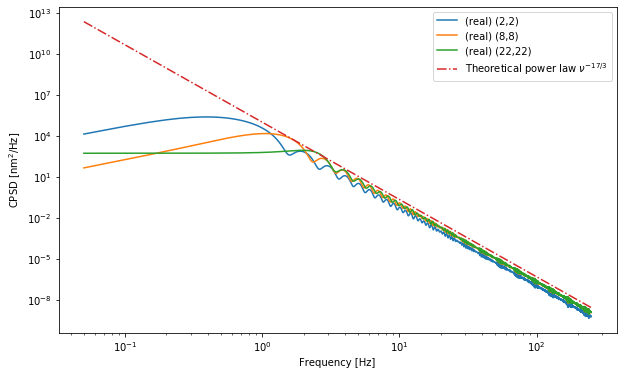

In [25]:
plt.figure()
vk.plotCPSD(zz22, temporal_freqs, 'real', 'log', '(2,2)')                                                             
vk.plotCPSD(zz88, temporal_freqs, 'real', 'log', '(8,8)')                                                             
vk.plotCPSD(zz22_22, temporal_freqs, 'real', 'log', '(22,22)')

def slope(x, m, q):
    return q*x**(m) 

theor_slope = slope(temporal_freqs, -17./3, 1e5)
plt.loglog(temporal_freqs, theor_slope, '-.', label='Theoretical power law $\\nu^{-17/3}$')
plt.legend()

# Slope of Zernike CPSD at low temporal frequencies

In [26]:
import numpy as np
from apposto.types.guide_source import GuideSource 
from apposto.types.aperture import CircularOpticalAperture 
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance 
from apposto.atmo.cn2_profile import Cn2Profile

rho, theta = (0,0)
aperture_radius = 5
aperture_centre = [0, 0, 0]
r0 = [0.16]
L0 = [25]
layers_altitude = [10e3]
wind_speed = [10]
wind_direction = [0]

source = GuideSource((rho, theta), np.inf)                                                                                                                                                                                    
aperture = CircularOpticalAperture(aperture_radius, aperture_centre)                                                                                   
cn2 = Cn2Profile.from_r0s(r0, L0, layers_altitude, wind_speed, wind_direction)
spatial_freqs = np.logspace(-3, 3, 100)                                                                                                     
temporal_freqs = np.linspace(0.05, 250, 5000)                                                                                           

vk = VonKarmanSpatioTemporalCovariance(source1=source, source2=source, aperture1=aperture, aperture2=aperture,
                                       cn2_profile=cn2, spat_freqs=spatial_freqs)

zz22 = vk.getZernikeCPSD(2, 2, temporal_freqs)
zz33 = vk.getZernikeCPSD(3, 3, temporal_freqs)

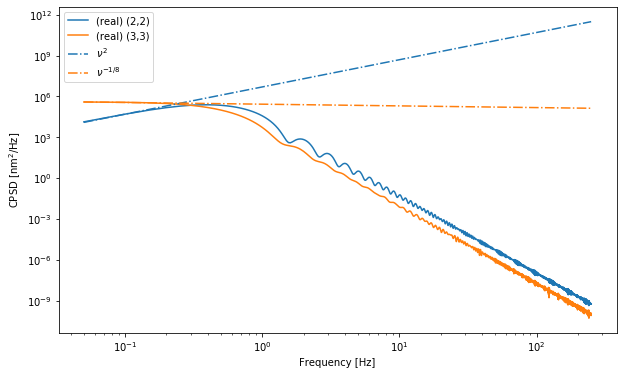

In [27]:
plt.figure()
vk.plotCPSD(zz22, temporal_freqs, 'real', 'log', '(2,2)')                                                             
vk.plotCPSD(zz33, temporal_freqs, 'real', 'log', '(3,3)')

def slope(x, m, q):
    return q*x**(m) 
slp_positive = slope(temporal_freqs, 2, 5e6)
slp_negative = slope(temp_freqs, -1/8, 2.7e5)

plt.loglog(temporal_freqs, slp_positive, '-.', color=cycle[0], label='$\\nu^{2}$')
plt.loglog(temporal_freqs, slp_negative, '-.', color=cycle[1], label='$\\nu^{-1/8}$')
plt.legend()